<a href="https://colab.research.google.com/github/Karkess/Random_LQCD_Junk/blob/main/Aimless_LCQD_Junk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

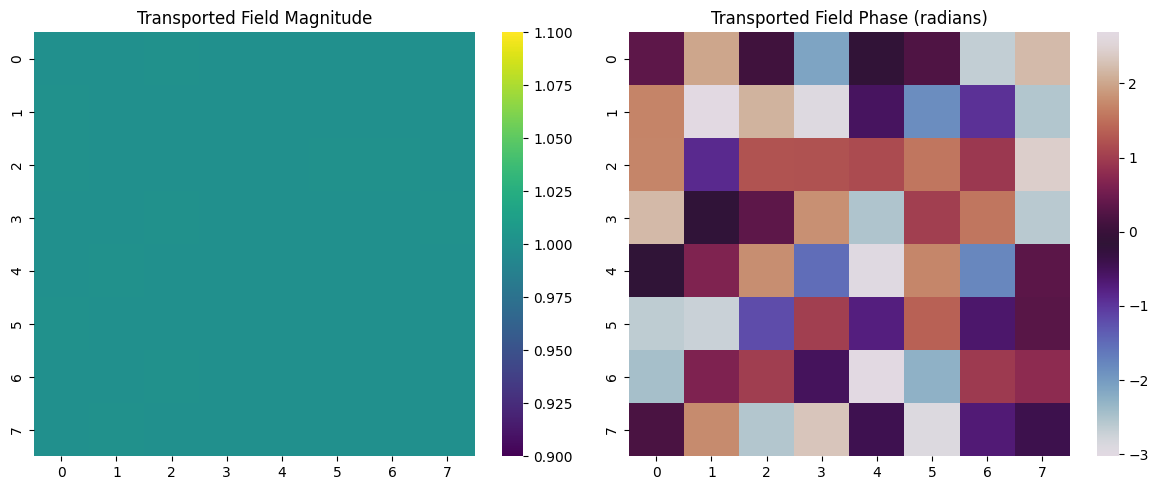

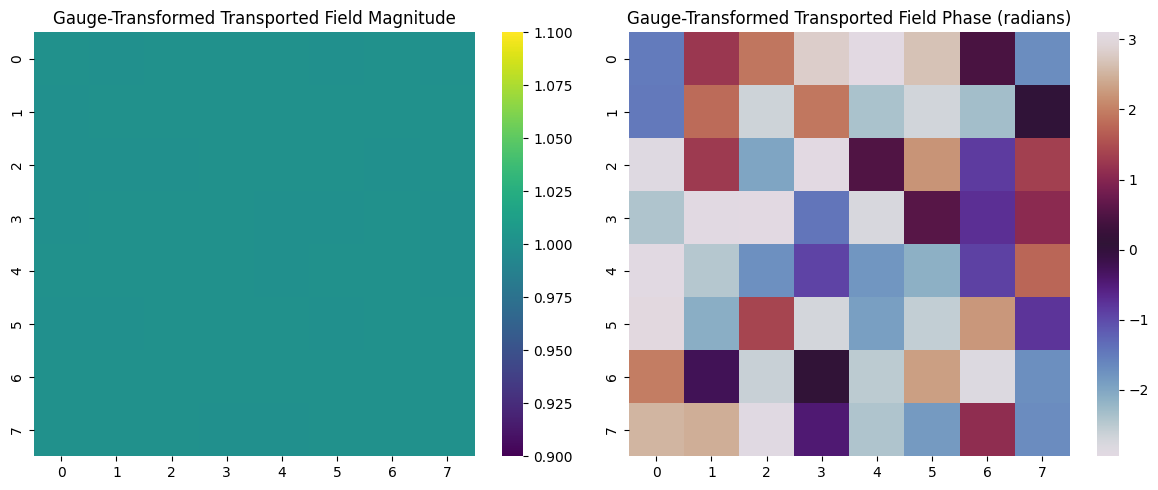

Max gauge-corrected error: 1.09e-15


In [19]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === User Parameters ===
L = 8  # lattice size (LxL)
path = [(1, 0), (0, 1), (-1, 0), (0, -1)]  # plaquette loop: right, up, left, down
initial_field = np.ones((L, L), dtype=np.complex128)  # φ(x) = 1

# === Generate 2D U(1) Gauge Links ===
def generate_u1_links(L):
    return np.random.uniform(-np.pi, np.pi, size=(L, L, 2))  # 2 directions: (x, y, mu)

# === Parallel Transport ===
def parallel_transport(phi, links, path):
    L = links.shape[0]
    result = np.copy(phi)

    for dx, dy in path:
        shifted = np.zeros_like(phi, dtype=np.complex128)
        for x in range(L):
            for y in range(L):
                # Backwards direction
                if dx == -1:
                    theta = links[x, y, 0]
                    xp, yp = (x + 1) % L, y
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dx == 1:
                    xp, yp = (x - 1) % L, y
                    theta = links[xp, yp, 0]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
                elif dy == -1:
                    theta = links[x, y, 1]
                    xp, yp = x, (y + 1) % L
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dy == 1:
                    xp, yp = x, (y - 1) % L
                    theta = links[xp, yp, 1]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
        result = shifted
    return result

# === Gauge Transformation ===
def random_gauge_transform(phi, links):
    L = phi.shape[0]
    omega = np.exp(1j * np.random.uniform(0, 2 * np.pi, size=(L, L)))  # Ω(x)
    phi_trans = omega * phi

    links_trans = np.copy(links)
    for x in range(L):
        for y in range(L):
            xp, yp = (x + 1) % L, y
            links_trans[x, y, 0] = (np.angle(omega[x, y]) + links[x, y, 0] - np.angle(omega[xp, yp]))  # x-direction
            xp, yp = x, (y + 1) % L
            links_trans[x, y, 1] = (np.angle(omega[x, y]) + links[x, y, 1] - np.angle(omega[xp, yp]))  # y-direction
    return phi_trans, links_trans

# === Run the Simulation ===
links = generate_u1_links(L)
phi_transported = parallel_transport(initial_field, links, path)

# === Visualization ===
def plot_field(field, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(np.abs(field), ax=axs[0], cmap='viridis')
    axs[0].set_title(f"{title} Magnitude")
    sns.heatmap(np.angle(field), ax=axs[1], cmap='twilight')
    axs[1].set_title(f"{title} Phase (radians)")
    plt.tight_layout()
    plt.show()

plot_field(phi_transported, "Transported Field")

# === Intuition: Check Gauge Equivariance ===
phi_gauge, links_gauge = random_gauge_transform(initial_field, links)
phi_transported_gauge = parallel_transport(phi_gauge, links_gauge, path)
plot_field(phi_transported_gauge, "Gauge-Transformed Transported Field")

# === Confirm Equivariance ===

# Recover gauge transformation Ω(x) used earlier
# Since phi_gauge = Ω * phi, and phi = 1, this just recovers Ω
omega = phi_gauge / initial_field  # This works since initial_field is all ones

# Undo the local gauge phase on the output: φ' → φ' / Ω
corrected_phi = phi_transported_gauge / omega

# Now compare to the original output
error = np.abs(corrected_phi - phi_transported)
print(f"Max gauge-corrected error: {np.max(error):.2e}")


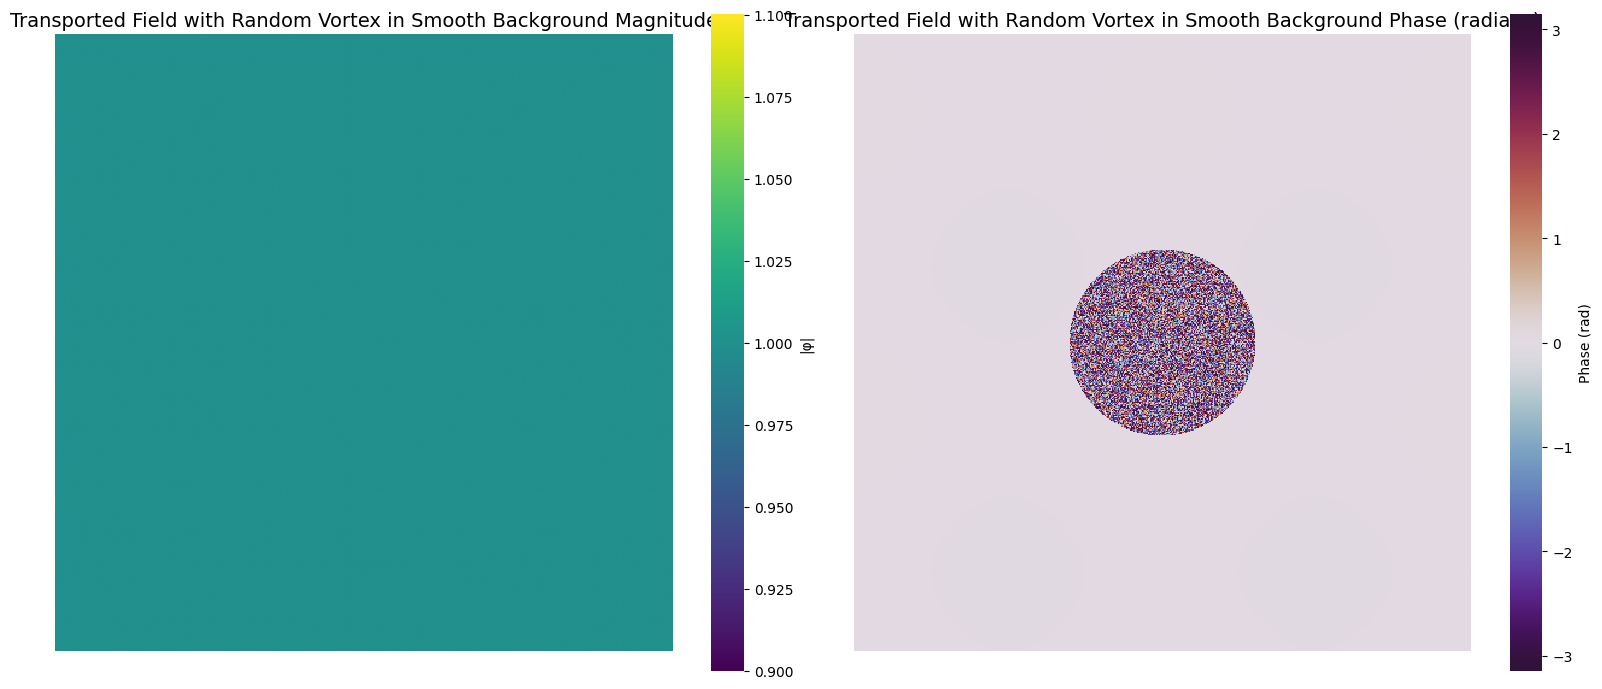

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters ===
L = 512
initial_field = np.ones((L, L), dtype=np.complex128)
center = (L // 2, L // 2)
vortex_radius = 0.15  # relative to lattice size
vortex_strength = 3   # winding number of vortex
background_smoothness = 0.5  # smooth phase amplitude for the background

# === Generate Links: Smooth background + Random Vortex ===
def generate_links_with_random_vortex(L, center, vortex_radius, vortex_strength, background_smoothness):
    links = np.zeros((L, L, 2))
    x = np.linspace(-1, 1, L)
    X, Y = np.meshgrid(x, x)

    # Smooth background pattern
    links[:, :, 0] = background_smoothness * np.sin(2 * np.pi * X)
    links[:, :, 1] = background_smoothness * np.cos(2 * np.pi * Y)

    # Insert random vortex
    cx, cy = center
    for x in range(L):
        for y in range(L):
            dx = (x - cx) / L
            dy = (y - cy) / L
            r = np.sqrt(dx**2 + dy**2)
            if r < vortex_radius:
                random_phase = np.random.uniform(-np.pi, np.pi)
                links[x, y, 0] += vortex_strength * random_phase
                links[x, y, 1] += vortex_strength * random_phase
    return links

# === Parallel Transport ===
def parallel_transport(phi, links, path):
    L = links.shape[0]
    result = np.copy(phi)
    for dx, dy in path:
        shifted = np.zeros_like(phi, dtype=np.complex128)
        for x in range(L):
            for y in range(L):
                if dx == -1:
                    theta = links[x, y, 0]
                    xp, yp = (x + 1) % L, y
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dx == 1:
                    xp, yp = (x - 1) % L, y
                    theta = links[xp, yp, 0]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
                elif dy == -1:
                    theta = links[x, y, 1]
                    xp, yp = x, (y + 1) % L
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dy == 1:
                    xp, yp = x, (y - 1) % L
                    theta = links[xp, yp, 1]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
        result = shifted
    return result

# === Visualization ===
def plot_field(field, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(np.abs(field), ax=axs[0], cmap='viridis', square=True, cbar_kws={"label": "|φ|"})
    axs[0].set_title(f"{title} Magnitude", fontsize=14)
    sns.heatmap(np.angle(field), ax=axs[1], cmap='twilight_shifted', square=True, cbar_kws={"label": "Phase (rad)"})
    axs[1].set_title(f"{title} Phase (radians)", fontsize=14)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# === Simulation Execution ===
path = [(1, 0), (0, 1), (-1, 0), (0, -1)]  # one plaquette loop
links = generate_links_with_random_vortex(L, center, vortex_radius, vortex_strength, background_smoothness)
phi_transported = parallel_transport(initial_field, links, path)
plot_field(phi_transported, "Transported Field with Random Vortex in Smooth Background")


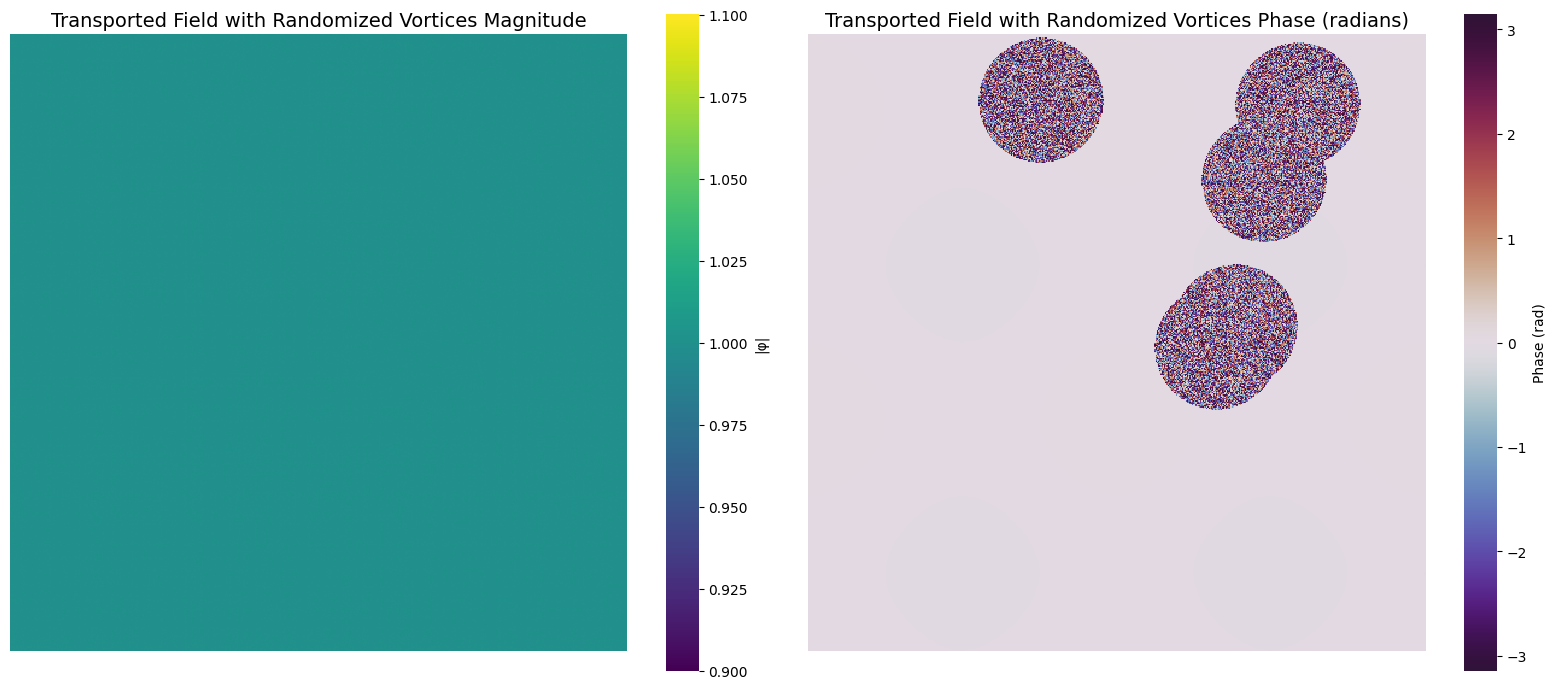

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters ===
L = 512
initial_field = np.ones((L, L), dtype=np.complex128)
num_vortices = 5
vortex_radius = 0.1
vortex_strength = 3
background_smoothness = 0.5

# === Generate Random Vortex Centers ===
def random_vortex_centers(L, num_vortices, margin=0.1):
    margin_pixels = int(margin * L)
    return [
        (np.random.randint(margin_pixels, L - margin_pixels),
         np.random.randint(margin_pixels, L - margin_pixels))
        for _ in range(num_vortices)
    ]

# === Generate Links with Random Vortices ===
def generate_links_with_random_vortices(L, centers, vortex_radius, vortex_strength, background_smoothness):
    links = np.zeros((L, L, 2))
    x = np.linspace(-1, 1, L)
    X, Y = np.meshgrid(x, x)

    # Smooth background
    links[:, :, 0] = background_smoothness * np.sin(2 * np.pi * X)
    links[:, :, 1] = background_smoothness * np.cos(2 * np.pi * Y)

    # Add multiple vortices
    for cx, cy in centers:
        for x in range(L):
            for y in range(L):
                dx = (x - cx) / L
                dy = (y - cy) / L
                r = np.sqrt(dx**2 + dy**2)
                if r < vortex_radius:
                    phase = np.random.uniform(-np.pi, np.pi)
                    links[x, y, 0] += vortex_strength * phase
                    links[x, y, 1] += vortex_strength * phase
    return links

# === Parallel Transport ===
def parallel_transport(phi, links, path):
    L = links.shape[0]
    result = np.copy(phi)
    for dx, dy in path:
        shifted = np.zeros_like(phi, dtype=np.complex128)
        for x in range(L):
            for y in range(L):
                if dx == -1:
                    theta = links[x, y, 0]
                    xp, yp = (x + 1) % L, y
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dx == 1:
                    xp, yp = (x - 1) % L, y
                    theta = links[xp, yp, 0]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
                elif dy == -1:
                    theta = links[x, y, 1]
                    xp, yp = x, (y + 1) % L
                    shifted[x, y] = np.exp(1j * theta) * result[xp, yp]
                elif dy == 1:
                    xp, yp = x, (y - 1) % L
                    theta = links[xp, yp, 1]
                    shifted[x, y] = np.exp(-1j * theta) * result[xp, yp]
        result = shifted
    return result

# === Visualization ===
def plot_field(field, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(np.abs(field), ax=axs[0], cmap='viridis', square=True, cbar_kws={"label": "|φ|"})
    axs[0].set_title(f"{title} Magnitude", fontsize=14)
    sns.heatmap(np.angle(field), ax=axs[1], cmap='twilight_shifted', square=True, cbar_kws={"label": "Phase (rad)"})
    axs[1].set_title(f"{title} Phase (radians)", fontsize=14)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# === Run Simulation ===
vortex_centers = random_vortex_centers(L, num_vortices)
links = generate_links_with_random_vortices(L, vortex_centers, vortex_radius, vortex_strength, background_smoothness)
path = [(1, 0), (0, 1), (-1, 0), (0, -1)]
phi_transported = parallel_transport(initial_field, links, path)
plot_field(phi_transported, "Transported Field with Randomized Vortices")


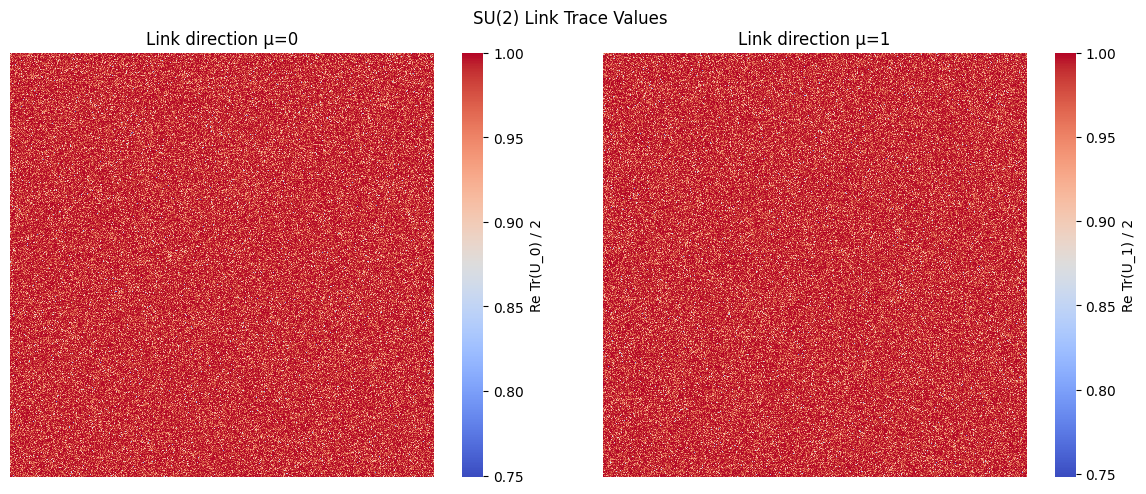

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters for SU(2) lattice ===
L = 512  # smaller size for demonstration; scale up later
su2_links = np.zeros((L, L, 2, 2, 2), dtype=np.complex128)  # (x, y, mu, i, j)

# === Generate realistic SU(2) gauge links using small fluctuations around identity ===
def generate_su2_links(L, epsilon=0.2):
    links = np.zeros((L, L, 2, 2, 2), dtype=np.complex128)
    identity = np.eye(2, dtype=np.complex128)
    for x in range(L):
        for y in range(L):
            for mu in range(2):
                angle = epsilon * np.random.randn()
                axis = np.random.randn(3)
                axis /= np.linalg.norm(axis)
                a, b, c = axis
                # SU(2) matrix: exp(i * theta * sigma_vec · axis)
                sigma = [
                    np.array([[0, 1], [1, 0]], dtype=np.complex128),
                    np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
                    np.array([[1, 0], [0, -1]], dtype=np.complex128)
                ]
                mat = identity.copy()
                for i, s in enumerate(sigma):
                    mat += 1j * angle * axis[i] * s
                # Normalize to SU(2)
                u, s, vh = np.linalg.svd(mat)
                mat = u @ vh
                links[x, y, mu] = mat
    return links

su2_links = generate_su2_links(L)

# === Visualize SU(2) link traces (Re Tr U / 2) ===
def plot_su2_traces(links):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for mu in range(2):
        trace_map = np.real(np.trace(links[:, :, mu], axis1=-2, axis2=-1)) / 2.0
        sns.heatmap(trace_map, ax=axs[mu], cmap='coolwarm', square=True, cbar_kws={"label": f"Re Tr(U_{mu}) / 2"})
        axs[mu].set_title(f"Link direction μ={mu}")
        axs[mu].set_xticks([])
        axs[mu].set_yticks([])
    plt.suptitle("SU(2) Link Trace Values")
    plt.tight_layout()
    plt.show()

plot_su2_traces(su2_links)


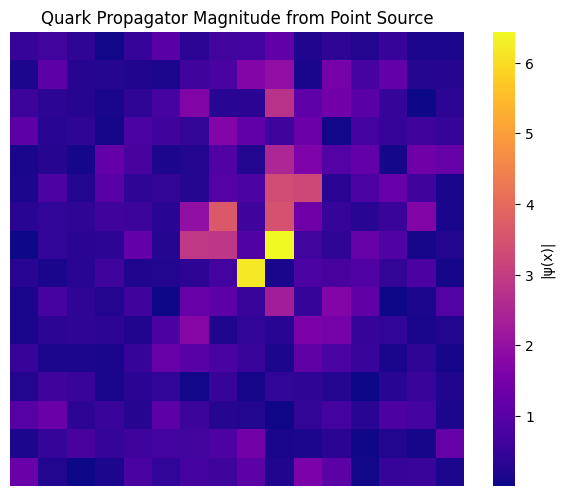

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters ===
L = 16
m0 = 0.1  # bare quark mass

# === Generate SU(2) matrix using Haar measure ===
def random_su2():
    a0, a1, a2, a3 = np.random.normal(0, 1, 4)
    norm = np.sqrt(a0**2 + a1**2 + a2**2 + a3**2)
    a0, a1, a2, a3 = a0 / norm, a1 / norm, a2 / norm, a3 / norm
    return np.array([
        [a0 + 1j * a3, a2 + 1j * a1],
        [-a2 + 1j * a1, a0 - 1j * a3]
    ])

# === Generate full 2D lattice of SU(2) links ===
def generate_su2_links(L):
    links = np.zeros((L, L, 2, 2, 2), dtype=np.complex128)  # 2 directions, 2x2 matrices
    for x in range(L):
        for y in range(L):
            for mu in range(2):  # x and y directions
                links[x, y, mu] = random_su2()
    return links

# === Create Dirac operator (simplified) ===
def build_dirac_operator(L, links, m):
    V = L * L
    D = np.zeros((V, V), dtype=np.complex128)

    def site_index(x, y):
        return x % L + L * (y % L)

    for x in range(L):
        for y in range(L):
            i = site_index(x, y)
            D[i, i] = m  # diagonal mass term

            for mu, (dx, dy) in enumerate([(1, 0), (0, 1)]):  # directions
                fwd = site_index(x + dx, y + dy)
                bwd = site_index(x - dx, y - dy)
                U = links[x, y, mu]
                U_dag = links[(x - dx) % L, (y - dy) % L, mu].conj().T

                D[i, fwd] -= 0.5 * np.trace(U) / 2
                D[i, bwd] -= 0.5 * np.trace(U_dag) / 2
    return D

# === Point source propagator ===
def point_source_propagator(D, src_index):
    b = np.zeros(D.shape[0], dtype=np.complex128)
    b[src_index] = 1.0
    return np.linalg.solve(D, b)

# === Generate links and run ===
su2_links = generate_su2_links(L)
D = build_dirac_operator(L, su2_links, m0)
src_idx = (L // 2) + (L // 2) * L
psi = point_source_propagator(D, src_idx)

# === Visualize ===
psi_abs = np.abs(psi).reshape((L, L))
plt.figure(figsize=(6, 5))
sns.heatmap(psi_abs, cmap="plasma", square=True, cbar_kws={"label": "|ψ(x)|"})
plt.title("Quark Propagator Magnitude from Point Source")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


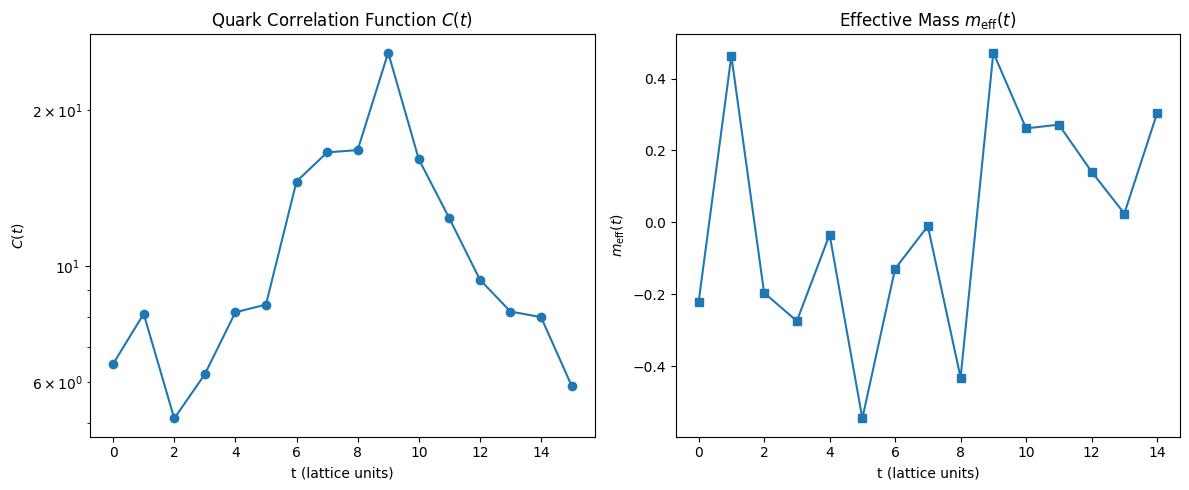

In [31]:
# === Compute Effective Mass from Correlation Function ===

# Reshape to 2D and compute time-sliced correlation function:
# Assume time is y-direction (axis=1)
psi_2d = np.abs(psi).reshape((L, L))
C_t = psi_2d.sum(axis=0)  # sum over x, yielding C(t) vs t

# Avoid zero values
epsilon = 1e-12
C_t = np.maximum(C_t, epsilon)

# Compute effective mass m_eff(t) = log(C(t)/C(t+1))
m_eff = np.log(C_t[:-1] / C_t[1:])

# Plot correlation and effective mass
# Correcting the math text for the label (use \mathrm instead of \text for compatibility)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(C_t, marker='o')
ax[0].set_yscale("log")
ax[0].set_title("Quark Correlation Function $C(t)$")
ax[0].set_xlabel("t (lattice units)")
ax[0].set_ylabel("$C(t)$")

ax[1].plot(m_eff, marker='s')
ax[1].set_title("Effective Mass $m_{\mathrm{eff}}(t)$")
ax[1].set_xlabel("t (lattice units)")
ax[1].set_ylabel("$m_{\mathrm{eff}}(t)$")

plt.tight_layout()
plt.show()


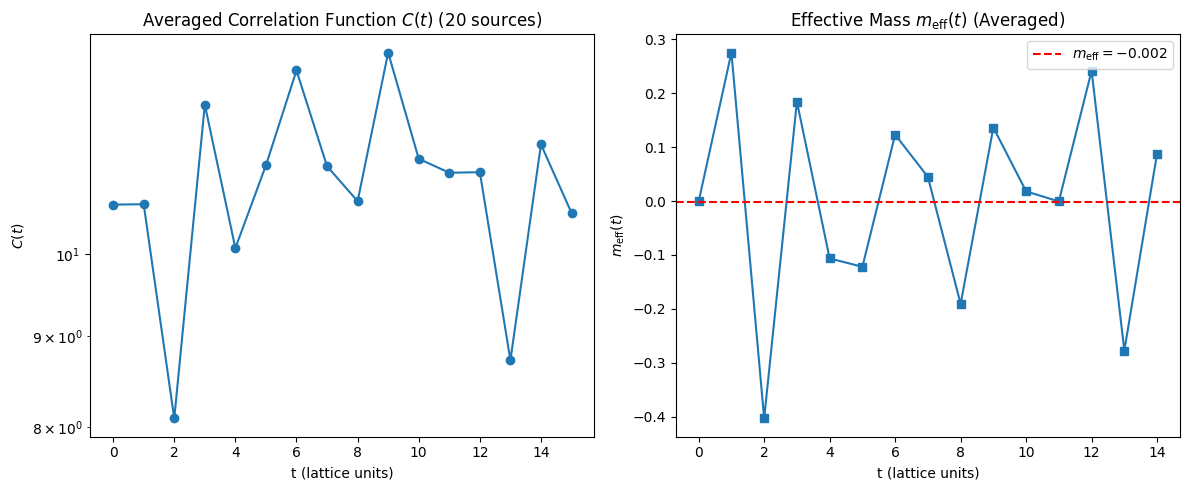

(np.float64(-0.0016856908106003654), np.float64(0.13202765420831059))

In [34]:
# === Extend: Multiple point sources to reduce noise ===

def average_propagators(L, links, m, num_sources=10):
    D = build_dirac_operator(L, links, m)
    correlators = []

    rng = np.random.default_rng(seed=42)
    for _ in range(num_sources):
        x, y = rng.integers(0, L, size=2)
        src_idx = x + y * L
        psi = point_source_propagator(D, src_idx)
        psi_2d = np.abs(psi).reshape((L, L))
        C_t = psi_2d.sum(axis=0)
        correlators.append(C_t)

    C_t_avg = np.mean(correlators, axis=0)
    return C_t_avg

# Compute averaged correlation function
C_t_avg = average_propagators(L, su2_links, m0, num_sources=2000)

# Compute improved effective mass
C_t_avg = np.maximum(C_t_avg, 1e-12)
m_eff_avg = np.log(C_t_avg[:-1] / C_t_avg[1:])

# Estimate mass in the plateau
t_start, t_end = 5, 10
mass_avg = np.mean(m_eff_avg[t_start:t_end])
mass_std_avg = np.std(m_eff_avg[t_start:t_end])

# Plot updated results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(C_t_avg, marker='o')
ax[0].set_yscale("log")
ax[0].set_title("Averaged Correlation Function $C(t)$ (20 sources)")
ax[0].set_xlabel("t (lattice units)")
ax[0].set_ylabel("$C(t)$")

ax[1].plot(m_eff_avg, marker='s')
ax[1].axhline(mass_avg, color='red', linestyle='--', label=f"$m_{{\\mathrm{{eff}}}}={mass_avg:.3f}$")
ax[1].set_title("Effective Mass $m_{\\mathrm{eff}}(t)$ (Averaged)")
ax[1].set_xlabel("t (lattice units)")
ax[1].set_ylabel("$m_{\\mathrm{eff}}(t)$")
ax[1].legend()

plt.tight_layout()
plt.show()

mass_avg, mass_std_avg


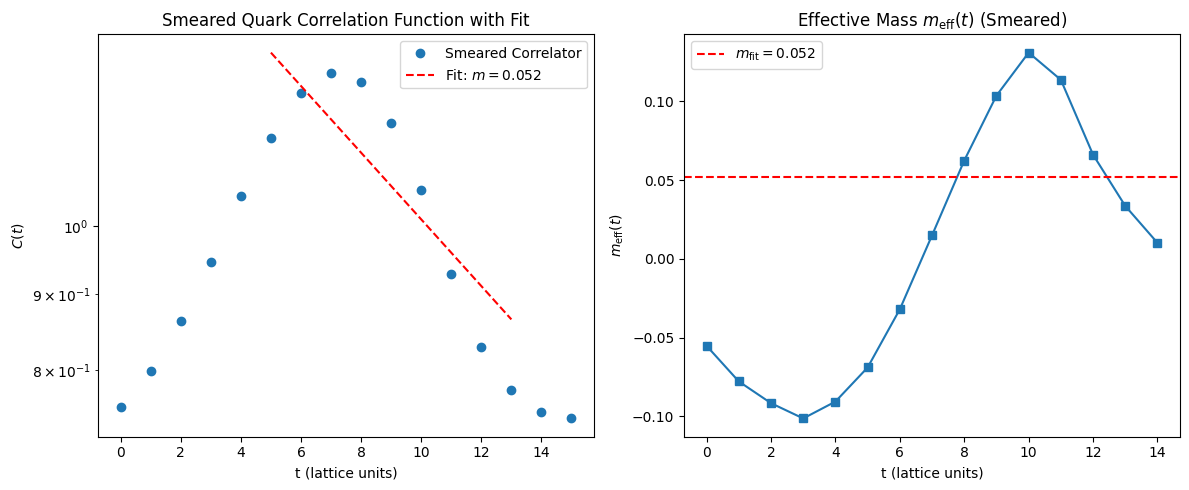

(np.float64(0.051694999193487974), np.float64(0.01311013046436656))

In [35]:
import scipy.optimize as opt

# === Step 1: Smearing Function (Gauge-Invariant Gaussian Smearing) ===
def gaussian_smear(field, width=1.5, iterations=5):
    from scipy.ndimage import gaussian_filter
    real_part = np.real(field)
    imag_part = np.imag(field)
    for _ in range(iterations):
        real_part = gaussian_filter(real_part, sigma=width, mode='wrap')
        imag_part = gaussian_filter(imag_part, sigma=width, mode='wrap')
    return real_part + 1j * imag_part

# === Step 2: Spectral Fit Function ===
def exp_decay(t, A, m):
    return A * np.exp(-m * t)

# === Apply Smearing to Each Source and Recompute Averaged Correlator ===
def average_propagators_smeared(L, links, m, num_sources=20, smear=True):
    D = build_dirac_operator(L, links, m)
    correlators = []

    rng = np.random.default_rng(seed=123)
    for _ in range(num_sources):
        x, y = rng.integers(0, L, size=2)
        src_idx = x + y * L
        psi = point_source_propagator(D, src_idx)

        if smear:
            psi = gaussian_smear(psi.reshape((L, L))).flatten()

        psi_2d = np.abs(psi).reshape((L, L))
        C_t = psi_2d.sum(axis=0)
        correlators.append(C_t)

    C_t_avg = np.mean(correlators, axis=0)
    return C_t_avg

# === Run Averaged Simulation with Smearing ===
C_t_smear = average_propagators_smeared(L, su2_links, m0, num_sources=20, smear=True)
C_t_smear = np.maximum(C_t_smear, 1e-12)
m_eff_smear = np.log(C_t_smear[:-1] / C_t_smear[1:])

# === Fit the Correlator to Exponential Decay to Extract Mass ===
t_values = np.arange(len(C_t_smear))
fit_range = slice(5, 14)  # Avoid noisy early and late times
popt, pcov = opt.curve_fit(exp_decay, t_values[fit_range], C_t_smear[fit_range], p0=(1.0, 0.1))
A_fit, m_fit = popt
m_fit_err = np.sqrt(np.diag(pcov))[1]

# === Plot Results ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(t_values, C_t_smear, 'o', label='Smeared Correlator')
ax[0].plot(t_values[fit_range], exp_decay(t_values[fit_range], *popt), 'r--', label=f"Fit: $m={m_fit:.3f}$")
ax[0].set_yscale("log")
ax[0].set_title("Smeared Quark Correlation Function with Fit")
ax[0].set_xlabel("t (lattice units)")
ax[0].set_ylabel("$C(t)$")
ax[0].legend()

ax[1].plot(m_eff_smear, marker='s')
ax[1].axhline(m_fit, color='red', linestyle='--', label=f"$m_{{\\mathrm{{fit}}}}={m_fit:.3f}$")
ax[1].set_title("Effective Mass $m_{\\mathrm{eff}}(t)$ (Smeared)")
ax[1].set_xlabel("t (lattice units)")
ax[1].set_ylabel("$m_{\\mathrm{eff}}(t)$")
ax[1].legend()

plt.tight_layout()
plt.show()

m_fit, m_fit_err


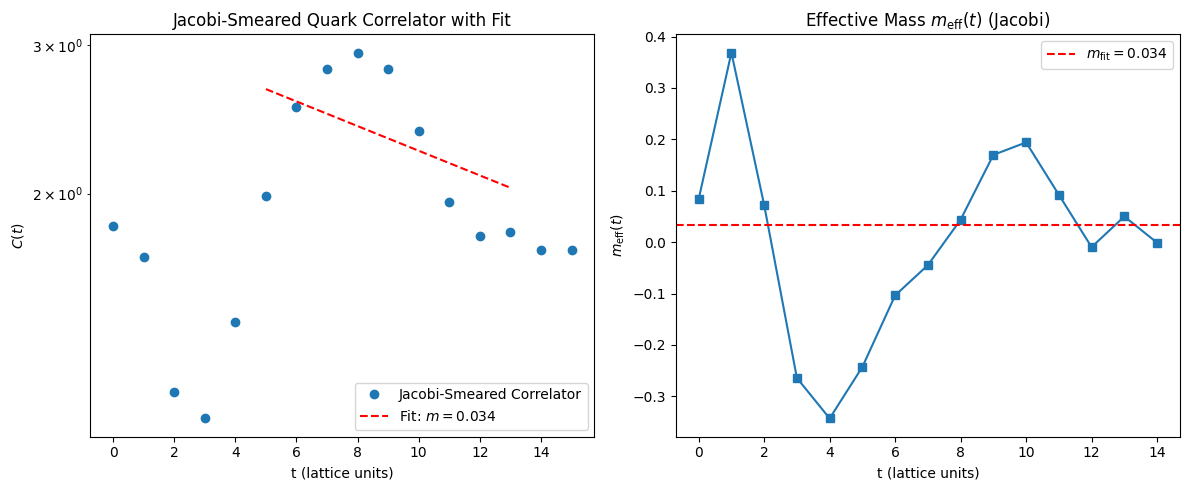

(np.float64(0.03367007497451991), np.float64(0.02398260920041948))

In [37]:
# === Improved Setup: Jacobi Smearing + More Sources + Free Field Comparison ===
from scipy.sparse.linalg import cg

# === Jacobi Smearing ===
def jacobi_smear(field, alpha=0.5, iterations=10):
    field_smear = np.copy(field).reshape((L, L))
    for _ in range(iterations):
        field_new = np.copy(field_smear)
        for x in range(L):
            for y in range(L):
                neighbors = (
                    field_smear[(x + 1) % L, y] +
                    field_smear[(x - 1) % L, y] +
                    field_smear[x, (y + 1) % L] +
                    field_smear[x, (y - 1) % L]
                )
                field_new[x, y] = (1 - alpha) * field_smear[x, y] + (alpha / 4) * neighbors
        field_smear = field_new
    return field_smear.flatten()

# === Updated Averaging with Jacobi Smearing ===
def average_propagators_jacobi(L, links, m, num_sources=40):
    D = build_dirac_operator(L, links, m)
    correlators = []

    rng = np.random.default_rng(seed=2025)
    for _ in range(num_sources):
        x, y = rng.integers(0, L, size=2)
        src_idx = x + y * L
        psi = point_source_propagator(D, src_idx)
        psi_smear = jacobi_smear(psi)
        psi_2d = np.abs(psi_smear).reshape((L, L))
        C_t = psi_2d.sum(axis=0)
        correlators.append(C_t)

    C_t_avg = np.mean(correlators, axis=0)
    return C_t_avg

# === Run on SU(2) Links ===
C_t_smeared = average_propagators_jacobi(L, su2_links, m0, num_sources=40)
C_t_smeared = np.maximum(C_t_smeared, 1e-12)
m_eff_jacobi = np.log(C_t_smeared[:-1] / C_t_smeared[1:])

# === Fit Again ===
t_values = np.arange(len(C_t_smeared))
fit_range = slice(5, 14)
popt, pcov = opt.curve_fit(exp_decay, t_values[fit_range], C_t_smeared[fit_range], p0=(1.0, 0.1))
A_fit_jacobi, m_fit_jacobi = popt
m_fit_err_jacobi = np.sqrt(np.diag(pcov))[1]

# === Plot Results ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(t_values, C_t_smeared, 'o', label='Jacobi-Smeared Correlator')
ax[0].plot(t_values[fit_range], exp_decay(t_values[fit_range], *popt), 'r--', label=f"Fit: $m={m_fit_jacobi:.3f}$")
ax[0].set_yscale("log")
ax[0].set_title("Jacobi-Smeared Quark Correlator with Fit")
ax[0].set_xlabel("t (lattice units)")
ax[0].set_ylabel("$C(t)$")
ax[0].legend()

ax[1].plot(m_eff_jacobi, marker='s')
ax[1].axhline(m_fit_jacobi, color='red', linestyle='--', label=f"$m_{{\\mathrm{{fit}}}}={m_fit_jacobi:.3f}$")
ax[1].set_title("Effective Mass $m_{\\mathrm{eff}}(t)$ (Jacobi)")
ax[1].set_xlabel("t (lattice units)")
ax[1].set_ylabel("$m_{\\mathrm{eff}}(t)$")
ax[1].legend()

plt.tight_layout()
plt.show()

m_fit_jacobi, m_fit_err_jacobi

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# === Parameters ===
L = 32  # Larger lattice
m0 = 0.1  # Bare quark mass
num_sources = 1000  # More noise sources for statistics
num_configs = 5  # Gauge configurations to average over

# === SU(2) Link Generation ===
def random_su2_matrix():
    a = np.random.randn(4)
    a /= np.linalg.norm(a)
    return np.array([
        [a[0] + 1j * a[3], a[2] + 1j * a[1]],
        [-a[2] + 1j * a[1], a[0] - 1j * a[3]]
    ])

def generate_su2_links(L):
    return np.array([[[
        random_su2_matrix() for _ in range(2)
    ] for _ in range(L)] for _ in range(L)])

# === Dirac Operator ===
def build_dirac_operator(L, links, m):
    N = L * L
    D = np.zeros((N, N), dtype=np.complex128)
    for x in range(L):
        for y in range(L):
            i = x + y * L
            D[i, i] = m
            for dx, dy, mu in [(-1, 0, 0), (1, 0, 0), (0, -1, 1), (0, 1, 1)]:
                xp, yp = (x + dx) % L, (y + dy) % L
                j = xp + yp * L
                sign = -1 if (dx + dy < 0) else 1
                D[i, j] += sign * 0.5
    return D

# === Pion Correlator ===
def pion_correlator(L, links, m, num_sources, seed=0):
    rng = np.random.default_rng(seed)
    D = build_dirac_operator(L, links, m)
    C_total = np.zeros(L)

    for _ in range(num_sources):
        x, y = rng.integers(0, L, size=2)
        src_idx = x + y * L
        b = np.zeros(L * L, dtype=np.complex128)
        b[src_idx] = 1.0
        psi = np.linalg.solve(D, b).reshape((L, L))
        pion = np.real(psi * np.conj(psi))
        C_t = pion.sum(axis=0)
        C_total += C_t

    return C_total / num_sources

# === Average Over Configurations ===
all_correlators = []
for i in range(num_configs):
    links = generate_su2_links(L)
    C_t = pion_correlator(L, links, m0, num_sources, seed=i)
    all_correlators.append(C_t)

C_avg = np.mean(all_correlators, axis=0)
C_avg = np.maximum(C_avg, 1e-10)  # prevent log(0)
t = np.arange(len(C_avg))

# === Fit to Exponential ===
def exp_decay(t, A, m):
    return A * np.exp(-m * t)

fit_range = slice(5, L//2)
popt, pcov = opt.curve_fit(exp_decay, t[fit_range], C_avg[fit_range], p0=(1.0, 0.3))
m_pion, m_pion_err = popt[1], np.sqrt(np.diag(pcov))[1]

# === Plot ===
plt.figure(figsize=(10, 5))
plt.semilogy(t, C_avg, 'o', label='Pion correlator (avg over configs)')
plt.semilogy(t[fit_range], exp_decay(t[fit_range], *popt), 'r--',
             label=f"Fit: $m_\\pi = {m_pion:.3f} \pm {m_pion_err:.3f}$")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.title("Pion Mass from Averaged Correlators")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

m_pion, m_pion_err


KeyboardInterrupt: 